In [ ]:
import pandas as pd
import re
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
file_paths = {
    "Innisfree": "data/innisfree.csv",
    "Sulwhasoo": "data/sulwhasoo.csv",
    "Glossier": "data/glossier.csv",
    "Laneige": "data/laneige.csv",
    "Tarte": "data/tarte_cosmetics.csv",
    "e.l.f.": "data/elf_cosmetics.csv",
    "Fenty Beauty": "data/fenty_beauty.csv",
    "Estée Lauder": "data/estee_lauder.csv",
    "Etude House": "data/etude_house.csv",
    "COSRX": "data/cosrx.csv"
}

In [9]:
basic_stopwords = set("""
a about above after again against all am an and any are aren't as at be because been before being below between both but by
can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't
have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is
isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or other ought our ours ourselves
out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves
then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd
we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would
wouldn't you you'd you'll you're you've your yours yourself yourselves
""".split())

In [10]:
text_data = []

for brand, path in file_paths.items():
    df = pd.read_csv(path)
    if 'text' in df.columns:
        for entry in df['text'].dropna():
            text_data.append({'brand': brand, 'text': str(entry)})

text_df = pd.DataFrame(text_data)

/var/folders/1b/hqv2rsp17t5gzv9rfwlmphm40000gn/T/ipykernel_51336/3419195833.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/1b/hqv2rsp17t5gzv9rfwlmphm40000gn/T/ipykernel_51336/3419195833.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/1b/hqv2rsp17t5gzv9rfwlmphm40000gn/T/ipykernel_51336/3419195833.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [ ]:
def preprocess(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation and numbers
    text = text.lower()
    tokens = text.split()
    filtered = [word for word in tokens if word not in basic_stopwords and len(word) > 2]
    return " ".join(filtered)

text_df['clean_text'] = text_df['text'].apply(preprocess)

In [14]:
text_df['sentiment'] = text_df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sentiment_summary = text_df.groupby('brand')['sentiment'].mean().reset_index()

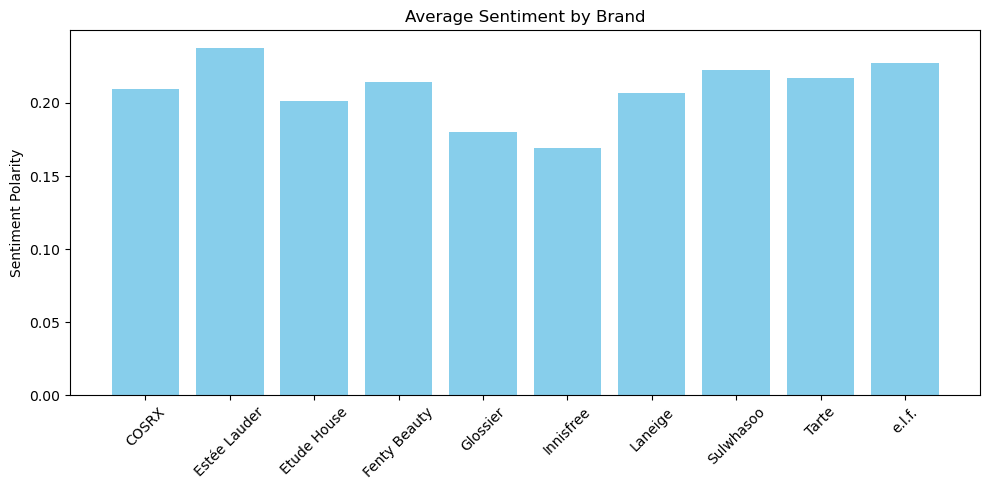

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(sentiment_summary['brand'], sentiment_summary['sentiment'], color='skyblue')
plt.title("Average Sentiment by Brand")
plt.ylabel("Sentiment Polarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# Vectorization and LDA topic modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(text_df['clean_text'])

lda_model = LDA(n_components=5, random_state=42)
lda_model.fit(doc_term_matrix)

# Show top words per topic
words = vectorizer.get_feature_names_out()
topics = []
for idx, topic in enumerate(lda_model.components_):
    top_words = [words[i] for i in topic.argsort()[-10:][::-1]]
    topics.append((f"Topic {idx+1}", top_words))

for topic, terms in topics:
    print(f"{topic}: {', '.join(terms)}")

Topic 1: redactedmention, beauty, innisfree, fenty, rihanna, kbeauty, stylevana, skincare, new, badgalriri
Topic 2: lauder, este, shop, beauty, sulwhasoo, link, laneige, bio, skincare, follow
Topic 3: makeup, beauty, fenty, foundation, lip, fentybeauty, powder, palette, blush, concealer
Topic 4: lip, glossier, beauty, like, products, makeup, love, new, laneige, hair
Topic 5: skin, cosrx, cream, serum, skincare, mask, toner, snail, cleanser, essence


In [ ]:
# Word cloud for each brand
for brand in text_df['brand'].unique():
    combined_text = " ".join(text_df[text_df['brand'] == brand]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {brand}")
    plt.tight_layout()
    plt.show()